# Importing Library

In [7]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Dataset

In [8]:
# Taking dataset from github
motor_data = pd.read_csv('https://raw.githubusercontent.com/Rentaku/ML_Price_Prediction/main/used-bikes.csv?token=GHSAT0AAAAAACDNTPRU27Y7FPRWICZLB6IYZD4HXYA')
motor_data.head()

,Summary,url,Title,Post_Details,Bike Type,Brand,Trim/Edition,Model,Year,Mileage,Seller,Capacity,Price
0,"Atv beach bike 201435,000 kmKegalle, Motorbike...",https://ikman.lk/en/ad/atv-beach-bike-2014-for...,Atv beach bike 2014,"Posted on 30 Jan 9:02 am, Kegalle City, Kegalle",Quadricycles,Other brand,Atv beach bike,Other model,2014,"35,000 km",lakee,150 cc,"Rs 440,000"
1,"Bajaj Pulsar 150 palsar 201450,737 kmAnuradhap...",https://ikman.lk/en/ad/bajaj-pulsar-150-palsar...,Bajaj Pulsar 150 palsar 2014,"Posted on 11 Mar 1:58 pm, Kekirawa, Anuradhapura",Motorbikes,Bajaj,palsar 150,Pulsar 150,2014,"50,737 km",Sasila Ishan,150 cc,"Rs 370,000"
2,"Beach Buggy 20055,000 kmColombo, MotorbikesRs ...",https://ikman.lk/en/ad/beach-buggy-2005-for-sa...,Beach Buggy 2005,"Posted on 21 Jan 9:45 pm, Talawatugoda, Colombo",Quadricycles,Other brand,Beach Buggy,Other model,2005,"5,000 km",vinuka automart,125 cc,"Rs 210,000"
3,"Electra Alpha Vino 2019600 kmColombo, Motorbik...",https://ikman.lk/en/ad/electra-alfa-vino-2019-...,Electra Alpha Vino 2019,"Posted on 22 Feb 2:26 pm, Moratuwa, Colombo",E-bikes,Electra,Vino,Alpha,2019,600 km,Jeewantha Basnayaka,49 cc,"Rs 105,000"
4,"Hero Maestro Edge 201818,500 kmMEMBERKalutara,...",https://ikman.lk/en/ad/hero-maestro-edge-2018-...,Hero Maestro Edge 2018,"Posted on 07 Mar 2:08 pm, Bandaragama, Kalutara",Scooters,Hero,2018,Maestro Edge,2018,"18,500 km",Anjalee Motors,110 cc,"Rs 80,000"


In [9]:
print(motor_data.info(), '\n') # View information on data
print(motor_data.isna().sum(), '\n') # Seeing the missing value in the data
print(motor_data.shape) # See data size

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5016 entries, 0 to 5015
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Summary       5016 non-null   object
 1   url           5016 non-null   object
 2   Title         5016 non-null   object
 3   Post_Details  5016 non-null   object
 4   Bike Type     5016 non-null   object
 5   Brand         5016 non-null   object
 6   Trim/Edition  3815 non-null   object
 7   Model         5016 non-null   object
 8   Year          5016 non-null   int64 
 9   Mileage       5016 non-null   object
 10  Seller        5013 non-null   object
 11  Capacity      5016 non-null   object
 12  Price         5016 non-null   object
dtypes: int64(1), object(12)
memory usage: 509.6+ KB
None 

Summary            0
url                0
Title              0
Post_Details       0
Bike Type          0
Brand              0
Trim/Edition    1201
Model              0
Year               0
Mileage       

In [10]:
# Dropped some features that are not needed for predictions
motor_data.drop(['Summary', 'url', 'Title', 'Post_Details','Trim/Edition','Seller' ],
                axis=1, inplace=True)

# Selecting the data category for the Bike Type feature, namely Motorbikes
motor_data = motor_data[motor_data['Bike Type'] == 'Motorbikes']

# Selecting motorcycle brands that only exist in Indonesia
values_to_fill = ['Electra', 'Hero', 'Honda', 'Kawasaki', 'Yamaha', 'Aprilia', 'Demak',
                  'Ducati', 'Kinetic', 'KTM', 'KYMCO', 'Loncin', 'Mahindra', 'Minnelli',
                  'Piaggio', 'Ranomoto', 'Royal Enfield', 'Scooty', 'Suzuki', 'Triumph',
                  'TVS', 'Vespa']
motor_data = motor_data[motor_data['Brand'].isin(values_to_fill)]

# Retrieve motor data with a feature year greater than or equal to 2000
motor_data = motor_data[motor_data['Year'] >= 2000] 

# Removing data from Model features which has other model values
motor_data = motor_data[motor_data['Model'] != 'Other Model']

# Fixed writing format and data type in some features
motor_data['Price'] = motor_data['Price'].str.replace('Rs ', '').str.replace(',', '').astype('float64')
motor_data['Mileage'] = motor_data['Mileage'].str.replace(' km', '').str.replace(',', '').astype('float64')

# change the currency from rupees to the rupiah exchange rate and multiply it by 4% to become the rental price
motor_data['Price'] = motor_data['Price']
for data in range(len(motor_data)):
    motor_data.iloc[data,6] = motor_data.iloc[data,6] * 70.2 * 0.4/100 

In [12]:
def remove_outliers(data, column):

"""
    This function works to separate data that has different ranges, such as too 
    high or too low (outliers) in the dataframe
"""

    Q1 = np.percentile(data[column], 25)
    Q3 = np.percentile(data[column], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data

In [13]:
# Use the remove_outlier functions
motor_data = remove_outliers(motor_data, 'Price')

# Checking data shape
motor_data.shape

(1610, 7)

In [14]:
# View unique data in each column of type object
print('Fitur Brand: \n', motor_data['Brand'].unique(), 
      '\n', motor_data['Brand'].unique().shape, '\n')
print('Fitur Model: \n', motor_data['Model'].unique(), '\n', 
      motor_data['Model'].unique().shape,'\n')
print('Fitur Year: \n', motor_data['Year'].unique(), 
      '\n', motor_data['Year'].unique().shape, '\n')
print('Fitur Capacity: \n', motor_data['Capacity'].unique(), '\n', 
      motor_data['Capacity'].unique().shape, '\n')

Fitur Brand: 
 ['Honda' 'Kawasaki' 'Aprilia' 'Demak' 'Ducati' 'Hero' 'Kinetic' 'KTM'
 'Loncin' 'Mahindra' 'Suzuki' 'TVS' 'Yamaha'] 
 (13,) 

Fitur Model: 
 ['CBR' 'Hornet' 'Magna' 'Balius' 'D Tracker' 'Tuono' 'Civic' 'D7' 'DTM'
 'DZM' 'DZR' 'Rio' 'Savage Supra' 'Sky Born' 'Skyline' 'Tropica' 'Warrior'
 'Monster' 'Achiever' 'CBZ' 'Dash' 'Dawn' 'Glamour' 'HF Dawn' 'HF Deluxe'
 'Hunk' 'Ignitor' 'Karizma' 'Passion Plus' 'Passion pro' 'Splender'
 'Splender i smart' 'Splender Plus' 'Super Splender' 'Xtream' 'AX1'
 'Benly' 'CB 125' 'CB Hornet' 'CB Shine' 'CB Trigger' 'CB Unicorn' 'CB4'
 'CD 110' 'CD 125' 'CD 70' 'CD 90' 'CD Down' 'CM Custom' 'Dream' 'FTR'
 'Jade' 'Little Cub' 'MD' 'Navi' 'NV400' 'Passion' 'PCX' 'Rebel' 'Stunner'
 'Super Club' 'Twister' 'VTR' 'X-Blade' 'XLR' 'XR' 'Zoomer' 'Estrella'
 'Ninja' 'Blaze' 'Boxer' 'Safari' '250' 'Duke' 'Duke 200' 'RC' '90' 'CD'
 'LD' 'LX' 'Centuro' 'Gusto' 'Uzo 125' 'Bandit' 'Djebel' 'DR' 'Gixxer'
 'GN 125' 'GN 250' 'Grass Tracker' 'GS 125' 'Intruder

In [15]:
def one_hot_encoded(data, category):

"""
    This function separates each category for each feature that has data 
    of type categorical into a new, completely separate column
"""

    one_hot_encoded = pd.get_dummies(data[category])
    fresh_data = pd.concat([data, one_hot_encoded], axis=1)
    return fresh_data 

In [16]:
# Implement one hot encoded function
encode = one_hot_encoded(motor_data, 'Brand')
encode = one_hot_encoded(encode, 'Model')
encode = one_hot_encoded(encode, 'Year')
clean_data = one_hot_encoded(encode, 'Capacity')
clean_data.columns = clean_data.columns.astype(str)

# Removed the original one hot encoding feature
clean_data.drop(['Bike Type', 'Brand', 'Model', 'Year', 'Capacity'], axis=1, inplace=True)
clean_data = clean_data.reset_index(drop=True) # Reset data index

In [17]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data
scaler.fit(clean_data.drop(['Price'],axis=1))

# Transform the data
normalized_data = scaler.transform(clean_data.drop(['Price'],axis=1))
normalized_df = pd.DataFrame(normalized_data, columns=clean_data.drop(['Price'],axis=1).columns)
normalized_df['Price'] = clean_data['Price']

# Lowercase each feature names
normalized_df.columns = normalized_df.columns.str.lower()

In [18]:
# Looking up the dataset
normalized_df

,mileage,aprilia,demak,ducati,hero,honda,ktm,kawasaki,kinetic,loncin,...,696 cc,70 cc,75 cc,"8,000 cc",80 cc,85 cc,89 cc,90 cc,99 cc,price
0,0.013291,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249631.2
1,0.018028,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219024.0
2,0.024555,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119340.0
3,0.015257,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89856.0
4,0.020975,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,0.028134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193190.4
1606,0.084138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193190.4
1607,0.129885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42120.0
1608,0.084138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68796.0


# Split Data

In [19]:
# Define variabel for X and y
X = normalized_df.drop(['price'],axis=1)
y = normalized_df['price']

# Splitting the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01 , random_state = 42)

# Cheking the data shapes
print("X_train shape:", X_train.shape) 
print("X_test shape:", X_test.shape) 
print("y_train shape:", y_train.shape) 
print("y_test shape:", y_test.shape)

X_train shape: (1593, 207)
X_test shape: (17, 207)
y_train shape: (1593,)
y_test shape: (17,)


In [20]:
# Creating new metric for measure model performances
class RSquared(tf.keras.metrics.Metric):
    def __init__(self, name='r_squared', **kwargs):
        super(RSquared, self).__init__(name=name, **kwargs)
        self.total_residual = self.add_weight(name='total_residual', initializer='zeros')
        self.total_total = self.add_weight(name='total_total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
        total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
        self.total_residual.assign_add(residual)
        self.total_total.assign_add(total)

    def result(self):
        r2_score = 1 - tf.math.divide_no_nan(self.total_residual, self.total_total)
        return r2_score

    def reset_states(self):
        self.total_residual.assign(0.0)
        self.total_total.assign(0.0)

In [21]:
# Creating the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1028, activation='relu', input_shape=(207,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

# Define Callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch/20))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
             loss= 'mean_absolute_error',
             metrics= [RSquared()])

# Create history and train the model
history = model.fit(X_train,
          y_train,
          epochs=100,
          callbacks=[lr_schedule],
          validation_data=(X_test,y_test)
         )

Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 99033.3047 - r_squared: -2.4906

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric RSquared implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


50/50 [==============================] - 5s 37ms/step - loss: 98975.0391 - r_squared: -2.5032 - val_loss: 124774.1875 - val_r_squared: -3.0372 - lr: 1.0000e-05
Epoch 2/100
50/50 [==============================] - 1s 23ms/step - loss: 98974.8828 - r_squared: -2.4887 - val_loss: 124774.0000 - val_r_squared: -3.0372 - lr: 1.1220e-05
Epoch 3/100
50/50 [==============================] - 1s 26ms/step - loss: 98974.5312 - r_squared: -2.5341 - val_loss: 124773.4688 - val_r_squared: -3.0372 - lr: 1.2589e-05
Epoch 4/100
50/50 [==============================] - 1s 26ms/step - loss: 98973.6797 - r_squared: -2.5166 - val_loss: 124772.1016 - val_r_squared: -3.0371 - lr: 1.4125e-05
Epoch 5/100
50/50 [==============================] - 2s 32ms/step - loss: 98971.2812 - r_squared: -2.4830 - val_loss: 124768.2812 - val_r_squared: -3.0369 - lr: 1.5849e-05
Epoch 6/100
50/50 [==============================] - 2s 31ms/step - loss: 98964.3125 - r_squared: -2.4783 - val_loss: 124756.8828 - val_r_squared: -3.03

(1e-05, 1.0, 0.0, 100000.0)

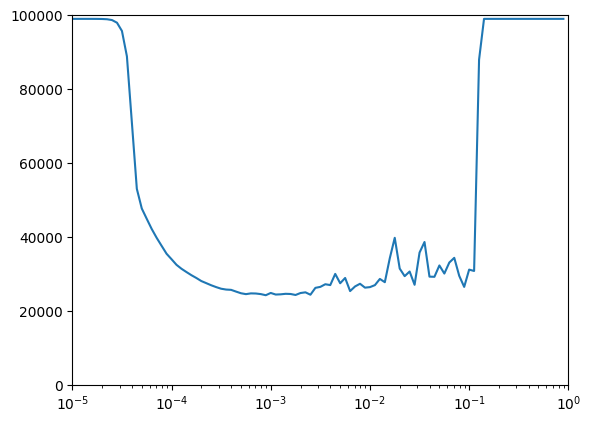

In [22]:
# Looking up learning rate performance
lrs = 1e-5 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history['loss'])  
plt.axis([1e-5, 1e-0, 0, 100000])

In [23]:
# Creating the new architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.08), input_shape=(207,)),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.08)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.08)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.08)),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.08)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.08)),
    tf.keras.layers.Dense(1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.08))
])

# Compiling the model again
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
             loss= 'mean_absolute_error',
             metrics= [RSquared()])

# Creating new history and train the model
history = model.fit(X_train,
          y_train,
          epochs=150,
          validation_data=(X_test,y_test)
         )

Epoch 1/150
50/50 [==============================] - 2s 17ms/step - loss: 97581.2891 - r_squared: -2.4510 - val_loss: 104550.9375 - val_r_squared: -2.1071
Epoch 2/150
 1/50 [..............................] - ETA: 0s - loss: 75328.1328 - r_squared: -1.1745

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric RSquared implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


50/50 [==============================] - 1s 15ms/step - loss: 46187.8086 - r_squared: 0.0082 - val_loss: 32351.4961 - val_r_squared: 0.5514
Epoch 3/150
50/50 [==============================] - 1s 13ms/step - loss: 32050.3105 - r_squared: 0.3952 - val_loss: 26372.5312 - val_r_squared: 0.6861
Epoch 4/150
50/50 [==============================] - 1s 14ms/step - loss: 28564.2656 - r_squared: 0.4876 - val_loss: 23995.0820 - val_r_squared: 0.6963
Epoch 5/150
50/50 [==============================] - 1s 18ms/step - loss: 27417.3418 - r_squared: 0.5203 - val_loss: 28321.4727 - val_r_squared: 0.6755
Epoch 6/150
50/50 [==============================] - 1s 19ms/step - loss: 27216.0820 - r_squared: 0.5354 - val_loss: 23378.9629 - val_r_squared: 0.6369
Epoch 7/150
50/50 [==============================] - 1s 19ms/step - loss: 26185.2129 - r_squared: 0.5572 - val_loss: 22702.0703 - val_r_squared: 0.6655
Epoch 8/150
50/50 [==============================] - 1s 15ms/step - loss: 25450.6367 - r_squared: 0.

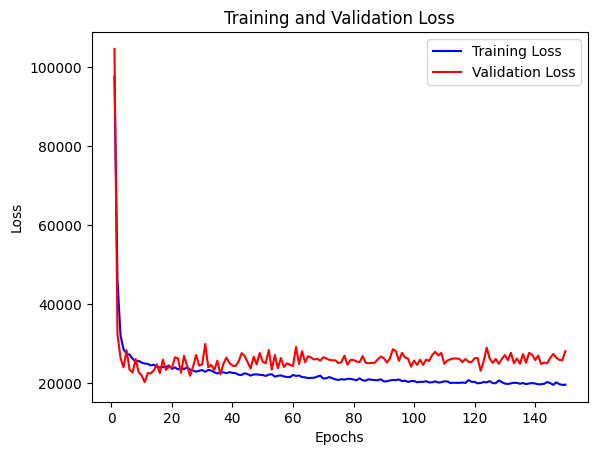

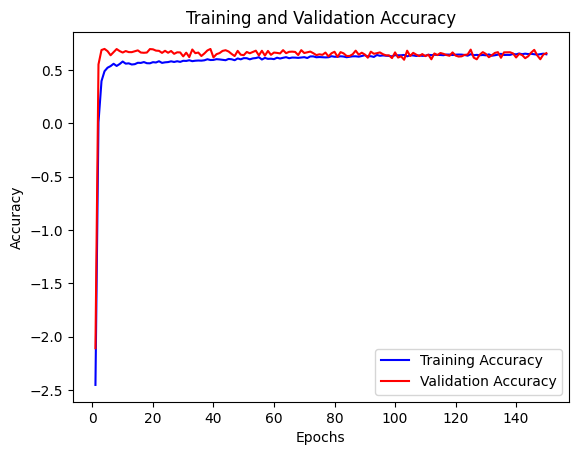

In [24]:
# Define error metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['r_squared']
val_acc = history.history['val_r_squared']

# Visualize training loss and validation loss
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize training accuracy and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [25]:
normalized_df

,mileage,aprilia,demak,ducati,hero,honda,ktm,kawasaki,kinetic,loncin,...,696 cc,70 cc,75 cc,"8,000 cc",80 cc,85 cc,89 cc,90 cc,99 cc,price
0,0.013291,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249631.2
1,0.018028,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219024.0
2,0.024555,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119340.0
3,0.015257,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89856.0
4,0.020975,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,245700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,0.028134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193190.4
1606,0.084138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193190.4
1607,0.129885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42120.0
1608,0.084138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68796.0


# Test model

In [ ]:
# Creating an variable to keep input values
input_value1 = input("Masukkan mileage: ")
input_value2 = input("Masukkan nama Brand: ")
input_value3 = input("Masukkan Model: ")
input_value4 = input("Masukkan Tahun: ")
input_value5 = input("Masukkan besar cc: ")

# Nama-nama kolom
column_names2 = normalized_df.columns[1:14]
column_names3 = normalized_df.columns[14:137]
column_names4 = normalized_df.columns[137:160]
column_names5 = normalized_df.columns[160:207]

# create a list based on the input values for each feature group
result_list = [input_value1] + \
              [1 if col == input_value2 else 0 for col in column_names2] + \
              [1 if col == input_value3 else 0 for col in column_names3] + \
              [1 if col == input_value4 else 0 for col in column_names4] + \
              [1 if col == input_value5 else 0 for col in column_names5] 

# Transforming list of data
data_predict = scaler.transform([result_list])

# Predicting the data using models
predictions = model.predict(data_predict)
print(predictions)

# Convert model to TFLite

In [26]:
export_dir = "../saved_model"
tf.saved_model.save(model, export_dir)


converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)


2433556

# Convert model to h5 and TFJS

In [29]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import time
saved_model_path = "./Untitled Folder/model.h5".format(int(time.time()))

model.save(saved_model_path)
! tensorflowjs_converter --input_format=keras /content/Untitled Folder/model.h5/model-h5

2023-06-04 07:54:11.489599: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 827, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 831, in main
    convert(argv[0].split(' '))
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 817, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 500, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_layers_model_conversion(
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 76, in di